In [54]:
from IPython.display import display
from pathlib import Path
import sys
import timeit
import os
from contextlib import nullcontext
import json

project_dir = Path(os.path.abspath('')).parent
if project_dir.as_posix() not in sys.path:
    sys.path.insert(0, project_dir.as_posix())

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({"font.size": 10, "lines.linewidth": 2})

from cs336_scaling.model import BasicsTransformerLM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

----- example -----
len: 72
parameters: 0.079 B
compute_budget: 6e+18
final_loss: 6.750171320661809


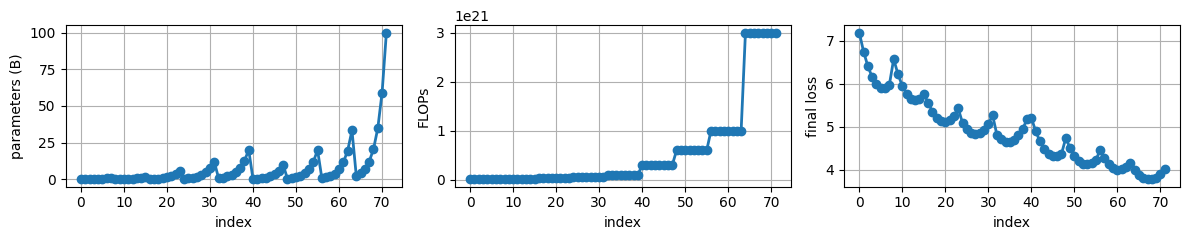

In [53]:
path = project_dir / "data" / "isoflops_curves.json"
with open(path, "r") as f:
    isoflops_data = json.load(f)

print("----- example -----")
print(f"len: {len(isoflops_data)}")
for k, v in isoflops_data[1].items():
    if k == "parameters":
        print(f"{k}: {v/1e9:.3f} B")
    else:
        print(f"{k}: {v}")

params = np.zeros(len(isoflops_data), dtype=float)
budgets = np.zeros(len(isoflops_data), dtype=float)
losses = np.zeros(len(isoflops_data), dtype=float)
for i, data in enumerate(isoflops_data):
    params[i] = data["parameters"]
    budgets[i] = data["compute_budget"]
    losses[i] = data["final_loss"]

fig, axes = plt.subplots(1, 3, figsize=(12, 2.5))
for i, key in enumerate(["params", "budgets", "losses"]):
    ax = axes[i]
    if key == "params":
        y = params / 1e9  # in billions
        ylabel = "parameters (B)"
    elif key == "budgets":
        y = budgets
        ylabel = "FLOPs"
    else:  # losses
        y = losses
        ylabel = "final loss"

    ax.plot(y, marker="o", linestyle="-")
    ax.set_xlabel("index")
    ax.set_ylabel(ylabel)
    ax.grid(True)
fig.tight_layout()

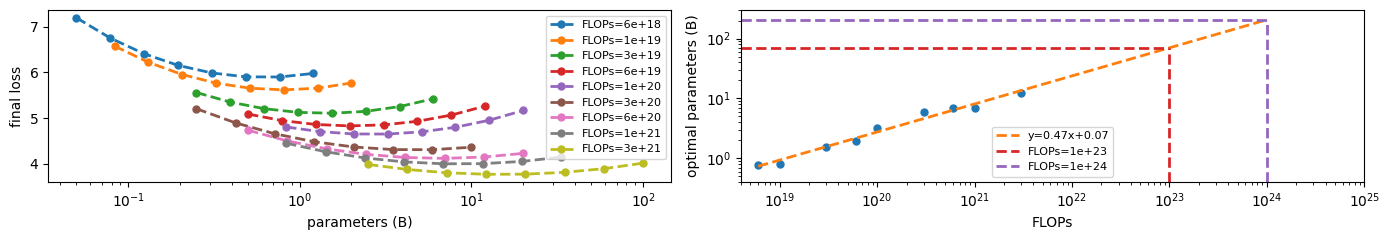

In [108]:
unique_budgets = np.unique(budgets)
param_group = {}
loss_group = {}
for budget in unique_budgets:
    param_group[budget] = params[budgets == budget]
    loss_group[budget] = losses[budgets == budget]

opt_params = []
fig, axes = plt.subplots(1, 2, figsize=(14, 2.5))
ax = axes[0]
ax.set_xlabel("parameters (B)")
ax.set_ylabel("final loss")
for budget in unique_budgets:
    param_vals = param_group[budget] / 1e9  # in billions
    loss_vals = loss_group[budget]
    opt_params.append(param_vals[loss_vals.argmin()] * 1e9)
    ax.plot(
        param_vals,
        loss_vals,
        marker="o",
        ms=5,
        linestyle="--",
        label=f"FLOPs={budget:.0e}",
    )
ax.legend(prop={"size": 8})
ax.set_xscale("log")

ax = axes[1]
opt_params = np.array(opt_params)
ax.plot(unique_budgets, opt_params / 1e9, marker="o", ms=5, ls="")
ax.set_xlabel("FLOPs")
ax.set_ylabel("optimal parameters (B)")
coeffs = np.polyfit(np.log10(unique_budgets), np.log10(opt_params), 1)
x = [unique_budgets[0], 1e24]
ax.plot(
    x,
    10 ** np.polyval(coeffs, np.log10(x)) / 1e9,
    ls="--",
    label=f"y={coeffs[0]:.2f}x+{coeffs[1]:.2f}",
)
get_opt_param = lambda flops: 10 ** np.polyval(coeffs, np.log10(flops))
for i, flops in enumerate([1e23, 1e24]):
    opt_param = get_opt_param(flops)
    ax.hlines(
        opt_param / 1e9, 4e18, flops, ls="--", color=f"C{i+3}", label=f"FLOPs={flops}"
    )
    ax.vlines(flops, 4e-1, opt_param / 1e9, ls="--", color=f"C{i+3}")
ax.set_xlim(4e18, 1e25)
ax.set_ylim(4e-1, 3e2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(prop={"size": 8}, loc="lower center")
fig.tight_layout()